###Packages###

In [1]:
!pip install tensorflow-addons

In [2]:
# Packages
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import IPython.display as display
import numpy as np
import PIL.Image
np.random.seed(7)

%matplotlib inline

print(tf.__version__)

2.5.0


###Layers and weights###

In [3]:
# metrics for keeping an eye for how learning is going
content_loss_metric = tf.keras.metrics.Mean()
style_loss_metric = tf.keras.metrics.Mean()
total_variation_loss_metric = tf.keras.metrics.Mean()
loss_metric = tf.keras.metrics.Mean()

# Content layer
content_layers = ['block4_conv1']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

# Custom weights for different style layers
style_weights = {'block1_conv1': 1.0,
                 'block2_conv1': 0.8,
                 'block3_conv1': 0.4,
                 'block4_conv1': 0.2,
                 'block5_conv1': 0.1}

# Custom weights for style, content and total_variation updates
style_weight=6e-4
content_weight=1.5
total_variation_weight=1

###Utils###

In [4]:
def load_img(path_to_img, resize=True, size=256):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
    
  if resize:
    img = tf.image.resize(img, [size, size])
        
  img = img[tf.newaxis, :]

  return img

In [5]:
def tensor_to_image(tensor):
  tensor = np.array(tensor*255, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [6]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [7]:
def gram_matrix(input_matrix):
  return tf.linalg.einsum('bijc,bijd->bcd', input_matrix, input_matrix)

In [8]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [9]:
class Custom_Style_Model(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(Custom_Style_Model, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    # Preprocess pixel values with respect to VGG19 stats
    preprocessed_input = preprocess_input(inputs*255)
    # Pass through the vgg network
    outputs = self.vgg(preprocessed_input)
    # Segregate the style and content representations
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    # Assign the content and style representation in dictionary
    content_dict = {content_name:value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}
                    
    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [10]:
def total_loss(outputs, content_targets, style_targets, image):
  content_outputs = outputs['content']
  style_outputs = outputs['style']

  a, n_H, n_W, n_C = content_outputs[content_layers[0]].shape
  F = content_outputs[content_layers[0]]
  P = content_targets[content_layers[0]]

  under_sum = (1/(n_H*n_W*n_C))*tf.square(F-P)
  content_loss = tf.reduce_sum(under_sum)
  
  style_loss=0
  for name in style_outputs.keys():
    a, n_H, n_W, n_C = style_outputs[name].shape
    gram_generated=gram_matrix(style_outputs[name])
    gram_style=gram_matrix(style_targets[name])
    under_sum = (1/(2*n_H*n_W*n_C)**2)*tf.square(gram_generated-gram_style)
    style_loss+=style_weights[name]*tf.reduce_sum(under_sum)
    
  style_loss = style_loss*style_weight/len(style_layers)
    
  content_loss = content_loss*content_weight

  total_variation_loss = total_variation_weight*tf.image.total_variation(image)

  content_loss_metric(content_loss)
  style_loss_metric(style_loss)
  total_variation_loss_metric(total_variation_loss)

  return style_loss + content_loss + total_variation_loss 

In [11]:
def transfer(content, weights):
  network = transform_net()
  network.load_weights(weights).expect_partial()

  image = load_img(content,True,1000)
  image = network(image)
  image = clip_0_1(image)

  display.clear_output(wait=True)
  display.display(tensor_to_image(image))

###Transform net###

In [12]:
class conv_2d(tf.keras.layers.Layer):
  def __init__(self, filters, kernel, stride):
    super(conv_2d, self).__init__()
    # reflection padding
    pad = kernel // 2
    self.paddings = tf.constant([[0, 0], [pad, pad],[pad, pad], [0, 0]])
    self.conv2d = tf.keras.layers.Conv2D(filters, kernel, stride, use_bias=False, padding='valid')
    self.instance_norm = tfa.layers.InstanceNormalization() 

  def call(self, inputs, relu=True):
    x = tf.pad(inputs, self.paddings, mode='REFLECT')
    x = self.instance_norm(self.conv2d(x))
    if relu:
      x = tf.nn.relu(x)
    return x

In [13]:
class upscale_conv_2d(tf.keras.layers.Layer):
  def __init__(self, filters, kernel, stride):
    super(upscale_conv_2d, self).__init__()
    self.conv = conv_2d(filters, kernel, stride)
    self.instance_norm = tfa.layers.InstanceNormalization() 
    self.stride = stride

  def call(self, inputs):
    new_h = inputs.shape[1] * self.stride * 2
    new_w = inputs.shape[2] * self.stride * 2
    x = tf.image.resize(inputs, [new_h, new_w], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    x = self.conv(x)
    return x

In [14]:
class residual_block(tf.keras.layers.Layer):
  def __init__(self, filters, kernel, stride):
    super(residual_block, self).__init__()
    self.conv1 = conv_2d(filters, kernel, stride)
    self.conv2 = conv_2d(filters, kernel, stride)

  def call(self, inputs):
    x = self.conv1(inputs)
    residual1 = inputs + self.conv2(x, relu=False)
    x = self.conv1(residual1)
    residual2 = residual1 + self.conv2(x, relu=False)
    x = self.conv1(residual2)
    residual3 = residual2 + self.conv2(x, relu=False)
    x = self.conv1(residual3)
    residual4 = residual3 + self.conv2(x, relu=False)
    x = self.conv1(residual4)
    residual5 = residual4 + self.conv2(x, relu=False)
    return residual5

In [15]:
class transform_net(tf.keras.models.Model):
  def __init__(self):
    super(transform_net, self).__init__()
    # [filters, kernel, stride]
    self.conv1 = conv_2d(32, 9, 1)     
    self.conv2 = conv_2d(64, 3, 2)           
    self.conv3 = conv_2d(128, 3, 2)     
    self.residualBlock = residual_block(128, 3, 1)     
    self.upscale_conv1 = upscale_conv_2d(64, 3, 2)
    self.upscale_conv2 = upscale_conv_2d(32, 3, 2)
    self.conv4 = conv_2d(3, 9, 1)              

  def call(self, inputs):
    x = self.conv3(self.conv2(self.conv1(inputs)))
    x = self.residualBlock(x)
    x = self.conv4(self.upscale_conv2(self.upscale_conv1(x)), relu=False)
    return tf.nn.tanh(x)

###Main program###

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
style_path = "/content/drive/MyDrive/starryNight.jpg"
dataset_path = "/content/drive/MyDrive/train2014_smaller"
weights_path ="/content/drive/MyDrive/StarryNightWeights/weights.tf"
content_path = "zamek.jpg"

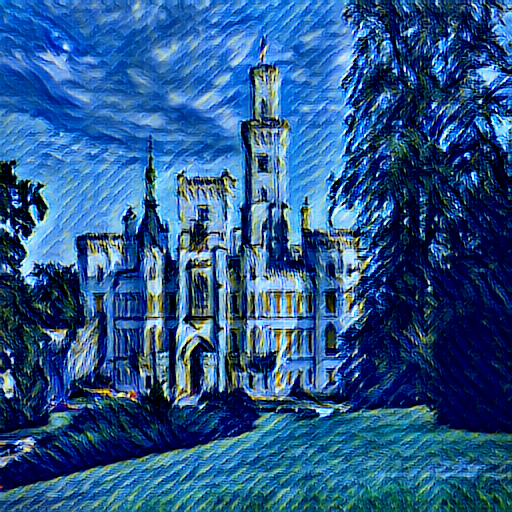

iteration 40000: total_loss = tf.Tensor(3515725.8, shape=(), dtype=float32)
content_loss = tf.Tensor(2444661.2, shape=(), dtype=float32)
style_loss = tf.Tensor(1035638.06, shape=(), dtype=float32)
tv_loss = tf.Tensor(35401.406, shape=(), dtype=float32)
-------------------------------------------------
Total time: 3953.8
Weights saved


In [18]:
img_check = load_img(content_path,True,512)

network = transform_net()

extractor = Custom_Style_Model(style_layers, content_layers)

style_image = load_img(style_path, True, 512)
style_target = extractor(style_image)['style']

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

@tf.function()
def train(target_img):
  with tf.GradientTape() as tape:
    # Extract the features
    content_target = extractor(target_img)['content']
    generated_img = network(target_img)
    outputs = extractor(generated_img)

    loss = total_loss(outputs, content_target, style_target, generated_img) 
    loss_metric(loss)
  gradient = tape.gradient(loss, network.trainable_variables)
  # Update the weights
  optimizer.apply_gradients(zip(gradient, network.trainable_variables))


dataset = tf.data.Dataset.list_files(dataset_path + '/*.jpg')
dataset = dataset.map(load_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

epochs = 4
save_weights = True

iteration = 0

import time
start = time.time()

for e in range(epochs):
  for img in dataset:
    iteration += 1
    train(img)

    if iteration % 1000 == 0:
      result = network(img_check)
      result = clip_0_1(result)
      display.clear_output(wait=True)
      display.display(tensor_to_image(result))
      print('iteration %s: total_loss = %s' % (iteration, loss_metric.result()))
      print('content_loss = %s' % (content_loss_metric.result()))
      print('style_loss = %s' % (style_loss_metric.result()))
      print('tv_loss = %s' % (total_variation_loss_metric.result()))
      print('-------------------------------------------------')


end = time.time()
print("Total time: {:.1f}".format(end-start))

if save_weights:
  network.save_weights(weights_path, save_format='tf')
  print("Weights saved")